In [56]:
from tiffConverter import convert_to_numpy
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tomoDataClass
# from scipy.ndimage import correlate
from scipy.ndimage import rotate
# from scipy.signal import correlate2d

In [57]:
fileLocation = "/Users/levih/Desktop/TomoMono/data/fullTomoReconstructions2.tif"
misalignedProjections, scale_info = convert_to_numpy(fileLocation)
print(misalignedProjections.shape)

(800, 750, 1134)


In [63]:
badProjections = tomoDataClass.tomoData(misalignedProjections)
badProjections.crop(900,550)

badProjections.cross_correlate_align()
badProjections.makeNotebookProjMovie()

Cross-Correlation Alignment of Projections: 100%|██████████| 800/800 [00:43<00:00, 18.55it/s]


Output()

In [59]:
# badProjections.normalize()

In [60]:
from scipy.ndimage import rotate
from scipy.signal import correlate
import numpy as np

def find_optimal_rotation(img1, img2, angle_range=(-10, 10), angle_step=1):
    """
    Calculates the rotation angle between two projections that maximizes their similarity.
    
    Parameters:
    - img1: The first projection image.
    - img2: The second projection image, which will be rotated to find the optimal alignment.
    - angle_range: A tuple (min_angle, max_angle) defining the range of angles to test.
    - angle_step: The granularity of angles to test within the range.
    
    Returns:
    - optimal_angle: The angle that maximizes the similarity between the two projections.
    - max_similarity: The maximum similarity score achieved.
    """
    # print("Finding optimal rotation")
    max_similarity = -np.inf
    optimal_angle = 0

    for angle in np.arange(angle_range[0], angle_range[1] + angle_step, angle_step):
        # Rotate img2 by the current angle
        rotated_img2 = rotate(img2, angle, reshape=False, mode='nearest')
        
        # Compute the similarity (cross-correlation) between img1 and the rotated img2
        similarity = np.max(correlate(img1, rotated_img2, mode='same'))
        
        # Update the optimal angle if the current similarity is the highest found so far
        if similarity > max_similarity:
            max_similarity = similarity
            optimal_angle = angle

    # print(f"Optimal rotation angle: {optimal_angle} degrees, Maximum similarity: {max_similarity}")
    return optimal_angle, max_similarity


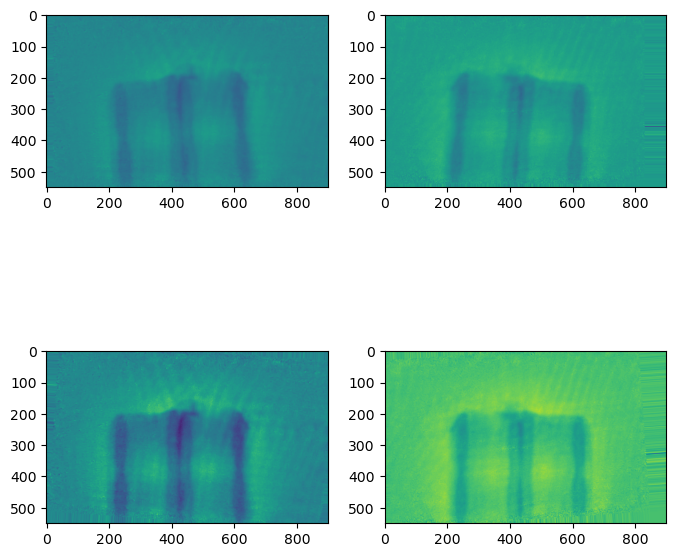

In [61]:
img1 = badProjections.get_projections()[100]
img2 = badProjections.get_projections()[500]

angle, maxSim = find_optimal_rotation(img1, img2)
fig1, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
axs[0,0].imshow(img1)
axs[0,1].imshow(img2)
axs[1,0].imshow(rotate(img1, -angle/2, reshape=False, mode='nearest'))
axs[1,1].imshow(rotate(img2, angle/2, reshape=False, mode='nearest'))

In [62]:
from tqdm import tqdm
data = badProjections.get_projections()

for i in tqdm(range(data.shape[0]//2), desc='rotation alignment'):
    angle, maxSim = find_optimal_rotation(data[i], data[(i+400)%800])
    data[i] = rotate(data[i], -angle/2, reshape=False, mode='nearest')
    data[(i+400)%800] = rotate(data[(i+400)%800], angle/2, reshape=False, mode='nearest')

badProjections = tomoDataClass.tomoData(data)
badProjections.makeNotebookProjMovie()

rotation alignment: 100%|██████████| 400/400 [09:00<00:00,  1.35s/it]


Output()